In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce

Load the images

In [94]:
dataset_path = Path('dataset')
left_path = dataset_path / 'left'
right_path = dataset_path / 'below'

left_image_paths = sorted(left_path.glob('*.png'))
right_image_paths = sorted(right_path.glob('*.png'))

left_images = []
right_images = []

for left_image, right_image in zip(left_image_paths, right_image_paths):
	left = cv2.imread(str(left_image))
	right = cv2.imread(str(right_image))
	left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
	right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
	# left = cv2.rotate(left, cv2.ROTATE_90_CLOCKWISE)
	# right = cv2.rotate(right, cv2.ROTATE_90_CLOCKWISE)
	left_images.append(left)
	right_images.append(right)

Create the Charuco dictionary

In [95]:
squaresX = 11
squaresY = 8
square_size = 0.05 # meters
marker_size = square_size * 0.8 # meters
aruco_dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard_create(
	squaresX, squaresY,
	square_size,
	marker_size,
	aruco_dictionary
)

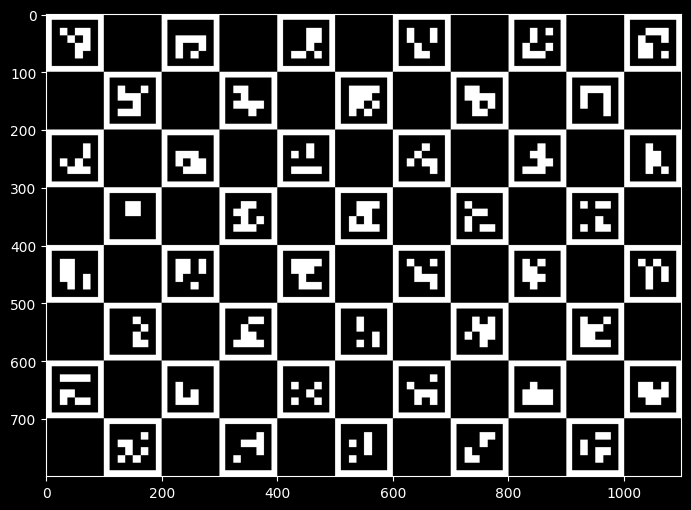

In [96]:
img = board.draw((squaresX * 100, squaresY * 100))
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')

### Analyze one image

In [97]:
img = left_images[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Detect markers

Detected 43 markers


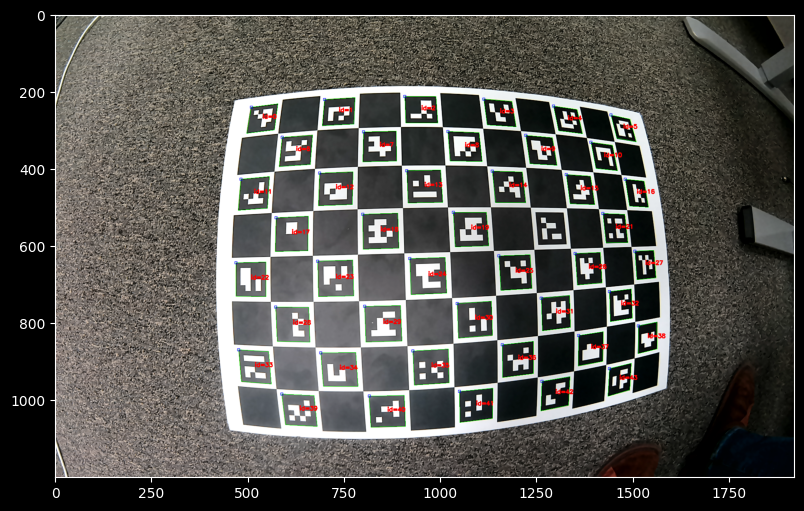

In [98]:
marker_corners, marker_ids, rejectedImgPoints = cv2.aruco.detectMarkers(
	img, aruco_dictionary)
marker_corners, marker_ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(
	img, board,
	marker_corners, marker_ids, rejectedCorners=rejectedImgPoints
)

print(f"Detected {len(marker_corners)} markers")

vis = cv2.aruco.drawDetectedMarkers(img.copy(), marker_corners, marker_ids)
plt.figure(figsize=(10, 6))
plt.imshow(vis)

Get chessboard corners

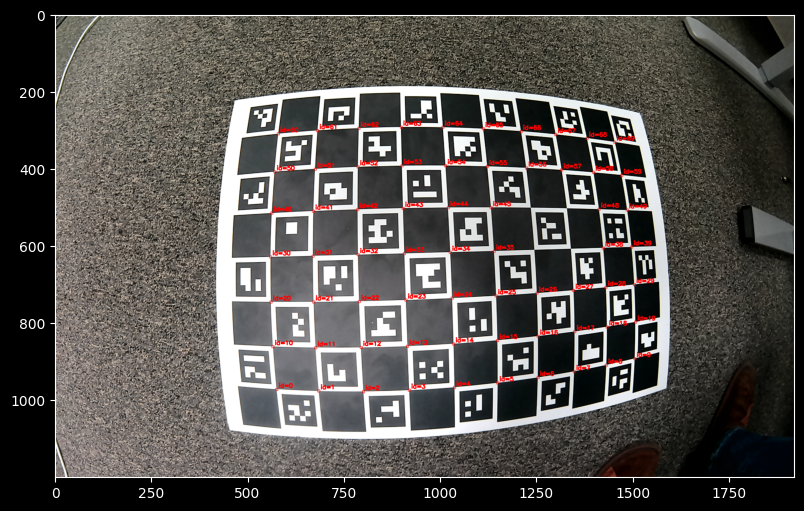

In [99]:
retval, corners, ids = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, img_gray, board)
vis = cv2.aruco.drawDetectedCornersCharuco(img.copy(), corners, ids)
plt.figure(figsize=(10, 6))
plt.imshow(vis)

Refine corners

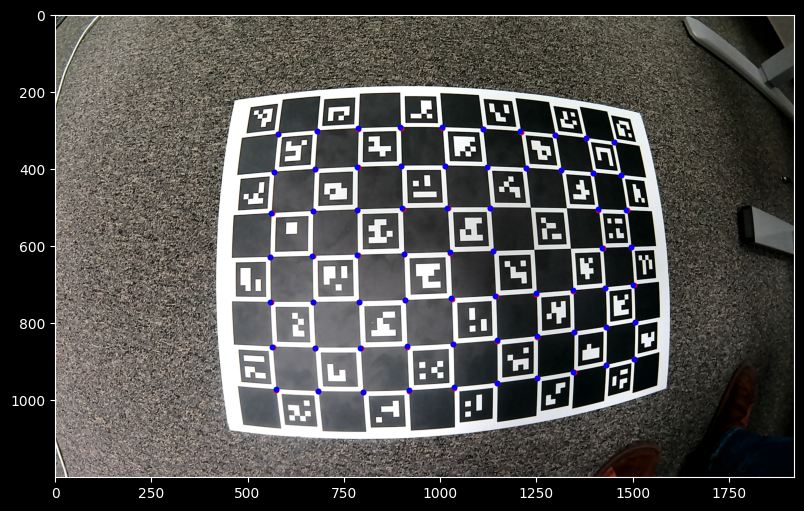

In [100]:
corners_subpix = cv2.cornerSubPix(img_gray, corners.copy(), (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))


plt.figure(figsize=(10, 6))
plt.scatter(corners[:, 0, 0], corners[:, 0, 1], c='r', s=10)
plt.scatter(corners_subpix[:, 0, 0], corners_subpix[:, 0, 1], c='b', s=10)
plt.imshow(img)

### Analyze all images

In [101]:
img_size = left_images[0].shape[1::-1]
print(img_size)

(1920, 1200)


In [102]:
def analyze_images(images):
	all_obj_points, all_img_points, all_ids = [], [], []
	for image in images:
		image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
		marker_corners, marker_ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dictionary)
		marker_corners, marker_ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(
			image, board,
			marker_corners, marker_ids, rejectedCorners=rejectedImgPoints
		)
		retval, corners, ids = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image_gray, board)
		corners_subpix = cv2.cornerSubPix(image_gray, corners.copy(), (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

		obj_points = board.chessboardCorners[ids]

		all_obj_points.append(obj_points)
		all_img_points.append(corners_subpix)
		all_ids.append(ids)

	return all_obj_points, all_img_points, all_ids

In [103]:
all_left_obj_points, all_left_img_points, all_left_ids = analyze_images(left_images)
all_right_obj_points, all_right_img_points, all_right_ids = analyze_images(right_images)

Compute intrinsic parameters of each camera

In [160]:
hfov = 95
f = img_size[0] / (2 * np.tan(np.deg2rad(hfov/2)))
camera_matrix_init = np.array([
    [f,     0,  img_size[1] / 2 ],
    [0.,    f,  img_size[0] / 2 ],
    [0.,    0.0,    1.0         ]
])

print(camera_matrix_init)

dist_coeffs_init = np.zeros(4)

term_criteria = (cv2.TERM_CRITERIA_COUNT +
                    cv2.TERM_CRITERIA_EPS, 1000, 1e-9)

flags = 0
flags |= cv2.fisheye.CALIB_CHECK_COND
# flags |= cv2.fisheye.CALIB_USE_INTRINSIC_GUESS 
flags |= cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
# flags |= cv2.fisheye.CALIB_FIX_SKEW
retval_l, K_l, D_l, _, _ = cv2.fisheye.calibrate(all_left_obj_points, all_left_img_points, img_size, camera_matrix_init.copy(), dist_coeffs_init.copy(), flags = flags, criteria = term_criteria)
retval_r, K_r, D_r, _, _ = cv2.fisheye.calibrate(all_right_obj_points, all_right_img_points, img_size, camera_matrix_init.copy(), dist_coeffs_init.copy(), flags = flags, criteria = term_criteria)
print(f"{retval_l=}\n\n camera matrix L=\n{K_l}\n\n dist coeff L={D_l.flatten()}")
print(f"{retval_r=}\n\n camera matrix R=\n{K_r}\n\n dist coeff R={D_r.flatten()}")

[[879.67792706   0.         600.        ]
 [  0.         879.67792706 960.        ]
 [  0.           0.           1.        ]]
retval_l=0.4753410213862954

 camera matrix L=
[[896.17878123  -0.51440761 937.49608786]
 [  0.         898.03167536 610.7782041 ]
 [  0.           0.           1.        ]]

 dist coeff L=[-0.017278   -0.0186494   0.02423497 -0.01176181]
retval_r=0.47926454341685465

 camera matrix R=
[[894.00807956  -0.39899568 991.17715186]
 [  0.         896.06352593 605.8862705 ]
 [  0.           0.           1.        ]]

 dist coeff R=[-0.01814263 -0.01386502  0.01313368 -0.00503652]


Make sure all images have the same points - this is important for `fisheye.stereoCalibrate` to work

In [161]:
# each image pair has to have the same points
all_common_obj_points = []
all_common_left_img_points = []
all_common_right_img_points = []
for left_ids, left_img_points, right_ids, right_img_points in zip(all_left_ids, all_left_img_points, all_right_ids, all_right_img_points):
	common_ids = np.intersect1d(left_ids, right_ids)
	common_obj_points = board.chessboardCorners[common_ids.reshape(-1, 1)]
	common_left_img_points = left_img_points[np.in1d(left_ids, common_ids)]
	common_right_img_points = right_img_points[np.in1d(right_ids, common_ids)]

	all_common_obj_points.append(common_obj_points)
	all_common_left_img_points.append(common_left_img_points)
	all_common_right_img_points.append(common_right_img_points)


# make sure that each image pair has the same number of points
min_num_points = min(len(obj_points) for obj_points in all_common_obj_points)
all_common_obj_points = [obj_points[:min_num_points] for obj_points in all_common_obj_points]
all_common_left_img_points = [img_points[:min_num_points] for img_points in all_common_left_img_points]
all_common_right_img_points = [img_points[:min_num_points] for img_points in all_common_right_img_points]

In [168]:

flags = 0
flags |= cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
flags |= cv2.fisheye.CALIB_CHECK_COND
# flags |= cv2.fisheye.CALIB_FIX_K1
# flags |= cv2.fisheye.CALIB_FIX_K2
# flags |= cv2.fisheye.CALIB_FIX_K3
# flags |= cv2.fisheye.CALIB_FIX_K4
# flags |= cv2.fisheye.CALIB_FIX_SKEW
# flags |= cv2.fisheye.CALIB_FIX_INTRINSIC
flags |= cv2.fisheye.CALIB_USE_INTRINSIC_GUESS

stereocalib_criteria = (cv2.TERM_CRITERIA_COUNT + cv2.TERM_CRITERIA_EPS, 10000, 1e-9)


ret_val_stereo, K_l, D_l, K_r, D_r, R, T = cv2.fisheye.stereoCalibrate(
	all_common_obj_points, all_common_left_img_points, all_common_right_img_points,
	K_l, D_l, K_r, D_r, img_size,
	criteria=stereocalib_criteria, flags=flags)

print(f'reprojection of Stereo is {ret_val_stereo}')
print(f'Left Camera Intrinsics of Stereo is {K_l}')
print(f'Right Camera Intrinsics of Stereo is {K_r}')
print(f'Left Camera distortion coeffs is {D_l}')
print(f'Right Camera distortion Coeffs is {D_r}')
print(f'Rotation between left and right is {R}')
print(f'Translation between left anf right is {T}')

reprojection of Stereo is 1.5506226970398789
Left Camera Intrinsics of Stereo is [[894.39203072  -0.13873983 942.33110242]
 [  0.         897.42485465 610.74494826]
 [  0.           0.           1.        ]]
Right Camera Intrinsics of Stereo is [[896.56373612  -0.90188107 984.93698131]
 [  0.         898.28659626 605.22059494]
 [  0.           0.           1.        ]]
Left Camera distortion coeffs is [ 0.01163303 -0.12124323  0.16368434 -0.07533489]
Right Camera distortion Coeffs is [-0.04048601  0.05726859 -0.07399755  0.03116234]
Rotation between left and right is [[ 0.99964806  0.00701237  0.02558482]
 [-0.00674527  0.999922   -0.01051121]
 [-0.02565653  0.01033493  0.99961739]]
Translation between left anf right is [[ 0.00196588]
 [ 0.04026829]
 [-0.00020273]]


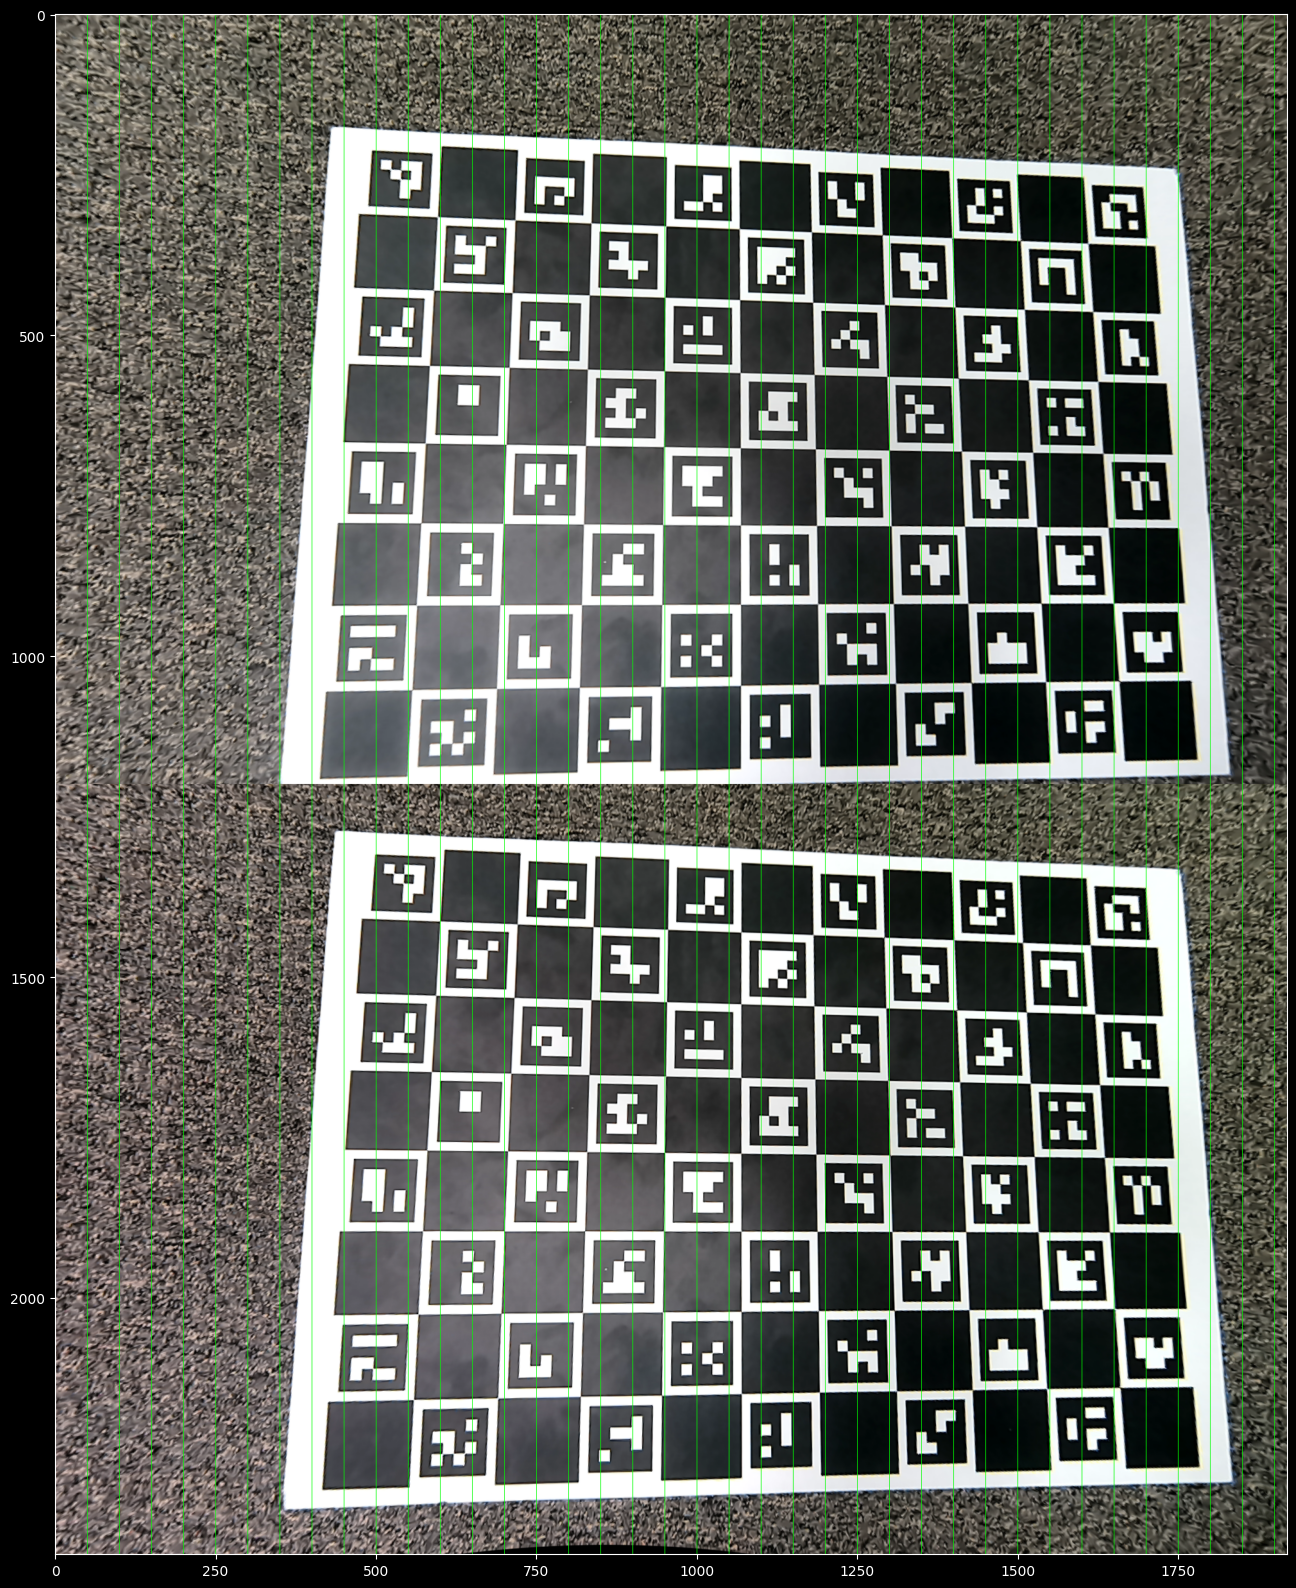

In [177]:
R_l, R_r, P_l, P_r, Q, _, _ = cv2.stereoRectify(K_l, D_l, K_r, D_r, img_size, R, T, flags=0, newImageSize=img_size)

rectify_map_l = cv2.fisheye.initUndistortRectifyMap(K=K_l, D=D_l, R=R_l, P=P_l, size=img_size, m1type=cv2.CV_32F)
rectify_map_r = cv2.fisheye.initUndistortRectifyMap(K=K_r, D=D_r, R=R_r, P=P_r, size=img_size, m1type=cv2.CV_32F)

img_l = cv2.remap(left_images[0], rectify_map_l[0], rectify_map_l[1], cv2.INTER_LINEAR)
img_r = cv2.remap(right_images[0], rectify_map_r[0], rectify_map_r[1], cv2.INTER_LINEAR)

img_side_by_side = np.vstack((img_l, img_r))

if T[0] < T[1]:
	img_side_by_side = np.vstack((img_l, img_r))
	for i in range(0, img_side_by_side.shape[1], 50):
		cv2.line(img_side_by_side, (i, 0), (i, img_side_by_side.shape[0]), (0, 255, 0), 1)
else:
	img_side_by_side = np.hstack((img_l, img_r))
	for i in range(0, img_side_by_side.shape[0], 50):
		cv2.line(img_side_by_side, (0, i), (img_side_by_side.shape[1], i), (0, 255, 0), 1)


plt.figure(figsize=(20, 20))
plt.imshow(img_side_by_side)